# 勾配ベース報酬 vs コサイン類似度ベース報酬 比較実験

この実験では、以下の2つのLinBandit-BOアルゴリズムを比較します：

1. **勾配ベースLinBandit-BO**: 勾配の絶対値を報酬として使用（スケーリングなし）
2. **コサイン類似度ベースLinBandit-BO**: 勾配と選択方向のコサイン類似度を報酬として使用

テスト関数：
- Styblinski-Tang
- Rastrigin
- Ackley

各関数について20回の独立実行を行い、収束履歴と最終性能を比較します。

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from copy import deepcopy
import pandas as pd

# BoTorch / GPyTorch
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

# デフォルトのdtypeをfloat32に設定
torch.set_default_dtype(torch.float32)

# プロット設定
plt.rcParams["figure.dpi"] = 100
plt.rcParams['figure.figsize'] = (12, 8)

# 日本語フォント設定
# 方法1: japanize-matplotlibを試す
try:
    import japanize_matplotlib
except ImportError:
    # 方法2: 手動でフォントを設定
    import matplotlib
    # Windowsの場合
    if os.name == 'nt':
        plt.rcParams['font.family'] = ['MS Gothic', 'Yu Gothic', 'Meiryo']
    # macOSの場合
    elif os.uname().sysname == 'Darwin':
        plt.rcParams['font.family'] = ['Hiragino Sans', 'Hiragino Maru Gothic Pro']
    # Linuxの場合
    else:
        plt.rcParams['font.family'] = ['IPAGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP', 'TakaoGothic']
    
    plt.rcParams['axes.unicode_minus'] = False

# フォント設定の確認
print(f"使用フォント: {plt.rcParams['font.family']}")

import warnings
warnings.filterwarnings("ignore")

# 出力フォルダの作成
output_dir = "output_results_cosine_similarity_comparison"
os.makedirs(output_dir, exist_ok=True)

print("実験環境の設定完了")

C:\Users\nomuyu\PycharmProjects\LinBandit-BO\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


使用フォント: ['IPAexGothic']
実験環境の設定完了


In [2]:
# 勾配ベースLinBandit-BO（L下限付きスケーリング）
class GradientLinBanditBO:
    """
    勾配ベースLinBandit-BO: 勾配の絶対値を報酬として使用し、推定L(=L_hat)でスケーリング（L_min下限を適用）
    """
    
    def __init__(self, objective_function, bounds, n_initial=5, n_max=100, 
                 coordinate_ratio=0.8, n_arms=None):
        self.objective_function = objective_function
        self.bounds = bounds.float()
        self.dim = bounds.shape[1]
        self.n_initial = n_initial
        self.n_max = n_max
        self.coordinate_ratio = coordinate_ratio
        
        # 0.5x arms設定
        self.n_arms = n_arms if n_arms is not None else max(1, self.dim // 2)
        
        # Linear Banditのパラメータ
        self.A = torch.eye(self.dim)
        self.b = torch.zeros(self.dim)
        
        # 初期点の生成
        self.X = torch.rand(n_initial, self.dim) * (bounds[1] - bounds[0]) + bounds[0]
        self.X = self.X.float()
        
        # 状態変数
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.eval_history = []
        self.theta_history = []
        self.scale_init = 1.0
        self.total_iterations = 0
        
        # 報酬履歴の記録
        self.reward_history = []
        self.direction_history = []
        
        # Lの推定と下限（スパイク抑制のため）
        self.L_min = 0.1
        self.L_hat = max(1.0, self.L_min)
        
    def update_model(self):
        """ガウス過程モデルの更新"""
        kernel = ScaleKernel(
            RBFKernel(ard_num_dims=self.X.shape[-1], dtype=torch.float32),
            dtype=torch.float32, noise_constraint=1e-3
        ).to(self.X)
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)
        
    def initialize(self):
        """初期化：初期点での評価とモデル構築"""
        y_val = self.objective_function(self.X)
        self.Y = y_val.unsqueeze(-1).float()
        
        # スケーリング係数の計算
        y_max, y_min = self.Y.max().item(), self.Y.min().item()
        self.scale_init = (y_max - y_min) if (y_max - y_min) != 0 else 1.0
        
        # モデルの初期化
        self.update_model()
        
        # 最良点の初期化
        post_mean = self.model.posterior(self.X).mean.squeeze(-1)
        bi = post_mean.argmin()
        self.best_value = post_mean[bi].item()
        self.best_point = self.X[bi]
        self.eval_history = [self.best_value] * self.n_initial
        
    def generate_arms(self):
        """アーム生成（0.5x arms）"""
        num_coord = int(self.coordinate_ratio * self.n_arms)
        num_coord = min(num_coord, self.dim)
        
        # ランダムに座標を選択
        idxs = np.random.choice(self.dim, num_coord, replace=False)
        
        # 座標方向の生成
        coords = []
        for i in idxs:
            e = torch.zeros(self.dim, device=self.X.device)
            e[i] = 1.0
            coords.append(e)
            
        coord_arms = torch.stack(coords, 0) if coords else torch.zeros(0, self.dim, device=self.X.device)
        
        # ランダム方向の生成
        num_rand = self.n_arms - num_coord
        rand_arms = torch.randn(num_rand, self.dim, device=self.X.device) if num_rand > 0 else torch.zeros(0, self.dim, device=self.X.device)
        
        if num_rand > 0:
            norms = rand_arms.norm(dim=1, keepdim=True)
            rand_arms = torch.where(norms > 1e-9, rand_arms / norms, 
                                   torch.randn_like(rand_arms) / (torch.randn_like(rand_arms).norm(dim=1,keepdim=True)+1e-9))
            
        return torch.cat([coord_arms, rand_arms], 0)
    
    def select_arm(self, arms_features):
        """Linear UCBによる方向選択"""
        # LinUCBパラメータ
        sigma = 1.0
        L = 1.0
        lambda_reg = 1.0
        delta = 0.1
        S = 1.0
        
        # 現在のパラメータ推定
        A_inv = torch.inverse(self.A)
        theta = A_inv @ self.b
        self.theta_history.append(theta.clone())
        
        # 信頼幅の計算
        current_round_t = max(1, self.total_iterations)
        log_term_numerator = max(1e-9, 1 + (current_round_t - 1) * L**2 / lambda_reg)
        beta_t = (sigma * math.sqrt(self.dim * math.log(log_term_numerator / delta)) + 
                  math.sqrt(lambda_reg) * S)
        
        # UCBスコアの計算
        ucb_scores = []
        for i in range(arms_features.shape[0]):
            x = arms_features[i].view(-1, 1)
            mean = (theta.view(1, -1) @ x).item()
            try:
                var = (x.t() @ A_inv @ x).item()
            except torch.linalg.LinAlgError:
                var = (x.t() @ torch.linalg.pinv(self.A) @ x).item()
                
            ucb_scores.append(mean + beta_t * math.sqrt(max(var, 0)))
            
        return int(np.argmax(ucb_scores))
    
    def propose_new_x(self, direction):
        """選択された方向に沿った最適化"""
        ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)
        
        # 方向に沿った探索範囲の計算
        active_dims_mask = direction.abs() > 1e-9
        if not active_dims_mask.any():
            lb, ub = -1.0, 1.0
        else:
            ratios_lower = (self.bounds[0] - self.best_point) / (direction + 1e-12 * (~active_dims_mask))
            ratios_upper = (self.bounds[1] - self.best_point) / (direction + 1e-12 * (~active_dims_mask))
            
            t_bounds = torch.zeros(self.dim, 2, device=self.X.device)
            t_bounds[:, 0] = torch.minimum(ratios_lower, ratios_upper)
            t_bounds[:, 1] = torch.maximum(ratios_lower, ratios_upper)
            
            lb = -float('inf')
            ub = float('inf')
            for i in range(self.dim):
                if active_dims_mask[i]:
                    lb = max(lb, t_bounds[i, 0].item())
                    ub = min(ub, t_bounds[i, 1].item())
                    
        if lb > ub:
            domain_width = (self.bounds[1, 0] - self.bounds[0, 0]).item()
            lb = -0.1 * domain_width
            ub = 0.1 * domain_width
            
        one_d_bounds = torch.tensor([[lb], [ub]], dtype=torch.float32, device=self.X.device)
        
        def ei_on_line(t_scalar_tensor):
            t_values = t_scalar_tensor.squeeze(-1)
            points_on_line = self.best_point.unsqueeze(0) + t_values.reshape(-1, 1) * direction.unsqueeze(0)
            points_on_line_clamped = torch.clamp(points_on_line, self.bounds[0].unsqueeze(0), self.bounds[1].unsqueeze(0))
            return ei(points_on_line_clamped.unsqueeze(1))
        
        # 獲得関数の最適化
        cand_t, _ = optimize_acqf(
            ei_on_line,
            bounds=one_d_bounds,
            q=1,
            num_restarts=10,
            raw_samples=100
        )
        
        alpha_star = cand_t.item()
        new_x = self.best_point + alpha_star * direction
        new_x_clamped = torch.clamp(new_x, self.bounds[0], self.bounds[1])
        
        return new_x_clamped
    
    def optimize(self):
        """メインの最適化ループ"""
        # 初期化
        self.initialize()
        n_iter = self.n_initial
        
        while n_iter < self.n_max:
            self.total_iterations += 1
            
            # 探索方向の候補生成
            arms_features = self.generate_arms()
            
            # Linear UCBによる方向選択
            sel_idx = self.select_arm(arms_features)
            direction = arms_features[sel_idx]
            
            # 方向を記録
            self.direction_history.append(direction.clone().detach().cpu().numpy())
            
            # 選択された方向に沿った最適化
            new_x = self.propose_new_x(direction)
            
            # 予測と実際の評価
            with torch.no_grad():
                predicted_mean = self.model.posterior(new_x.unsqueeze(0)).mean.squeeze().item()
            actual_y = self.objective_function(new_x.unsqueeze(0)).squeeze().item()
            
            # 報酬の計算（勾配ベース、L下限付きスケーリング）
            new_x_for_grad = new_x.clone().unsqueeze(0)
            new_x_for_grad.requires_grad_(True)
            
            # GPモデルで事後分布を取得
            posterior = self.model.posterior(new_x_for_grad)
            mean_at_new_x = posterior.mean
            
            # 勾配を計算
            mean_at_new_x.sum().backward()
            grad_vector = new_x_for_grad.grad.squeeze(0)
            
            # 報酬ベクトル（勾配の絶対値）
            reward_vector = grad_vector.abs()
            # L_hat更新（増加のみ）と下限定義
            grad_norm = reward_vector.norm().item()
            if grad_norm > self.L_hat:
                self.L_hat = grad_norm
            L_effective = max(self.L_hat, self.L_min)
            # 下限付きスケーリング
            reward_vector = reward_vector / L_effective
            
            # 報酬を記録
            self.reward_history.append(reward_vector.clone().detach().cpu().numpy())
            
            # Linear Banditパラメータの更新
            x_arm = direction.view(-1, 1)
            self.A += x_arm @ x_arm.t()
            self.b += reward_vector
            
            # データとモデルの更新
            self.X = torch.cat([self.X, new_x.unsqueeze(0)], 0)
            self.Y = torch.cat([self.Y, torch.tensor([[actual_y]], dtype=torch.float32, device=self.X.device)], 0)
            self.update_model()
            
            # 最良点の更新
            with torch.no_grad():
                posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
            current_best_idx = posterior_mean.argmin()
            self.best_value = posterior_mean[current_best_idx].item()
            self.best_point = self.X[current_best_idx]
            
            self.eval_history.append(self.best_value)
            n_iter += 1
                
        return self.best_point, self.best_value

print("勾配ベースLinBandit-BOクラスの定義完了")

勾配ベースLinBandit-BOクラスの定義完了


In [3]:
# コサイン類似度ベースLinBandit-BO
class CosineLinBanditBO:
    """
    コサイン類似度ベースLinBandit-BO: 勾配と選択方向のコサイン類似度を報酬として使用
    """
    
    def __init__(self, objective_function, bounds, n_initial=5, n_max=100, 
                 coordinate_ratio=0.8, n_arms=None):
        self.objective_function = objective_function
        self.bounds = bounds.float()
        self.dim = bounds.shape[1]
        self.n_initial = n_initial
        self.n_max = n_max
        self.coordinate_ratio = coordinate_ratio
        
        # 0.5x arms設定
        self.n_arms = n_arms if n_arms is not None else max(1, self.dim // 2)
        
        # Linear Banditのパラメータ
        self.A = torch.eye(self.dim)
        self.b = torch.zeros(self.dim)
        
        # 初期点の生成
        self.X = torch.rand(n_initial, self.dim) * (bounds[1] - bounds[0]) + bounds[0]
        self.X = self.X.float()
        
        # 状態変数
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.eval_history = []
        self.theta_history = []
        self.scale_init = 1.0
        self.total_iterations = 0
        
        # 報酬履歴の記録
        self.reward_history = []
        self.cosine_similarity_history = []
        self.direction_history = []
        self.gradient_history = []
        
    def update_model(self):
        """ガウス過程モデルの更新"""
        kernel = ScaleKernel(
            RBFKernel(ard_num_dims=self.X.shape[-1], dtype=torch.float32),
            dtype=torch.float32, noise_constraint=1e-3
        ).to(self.X)
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)
        
    def initialize(self):
        """初期化：初期点での評価とモデル構築"""
        y_val = self.objective_function(self.X)
        self.Y = y_val.unsqueeze(-1).float()
        
        # スケーリング係数の計算
        y_max, y_min = self.Y.max().item(), self.Y.min().item()
        self.scale_init = (y_max - y_min) if (y_max - y_min) != 0 else 1.0
        
        # モデルの初期化
        self.update_model()
        
        # 最良点の初期化
        post_mean = self.model.posterior(self.X).mean.squeeze(-1)
        bi = post_mean.argmin()
        self.best_value = post_mean[bi].item()
        self.best_point = self.X[bi]
        self.eval_history = [self.best_value] * self.n_initial
        
    def generate_arms(self):
        """アーム生成（0.5x arms）"""
        num_coord = int(self.coordinate_ratio * self.n_arms)
        num_coord = min(num_coord, self.dim)
        
        # ランダムに座標を選択
        idxs = np.random.choice(self.dim, num_coord, replace=False)
        
        # 座標方向の生成
        coords = []
        for i in idxs:
            e = torch.zeros(self.dim, device=self.X.device)
            e[i] = 1.0
            coords.append(e)
            
        coord_arms = torch.stack(coords, 0) if coords else torch.zeros(0, self.dim, device=self.X.device)
        
        # ランダム方向の生成
        num_rand = self.n_arms - num_coord
        rand_arms = torch.randn(num_rand, self.dim, device=self.X.device) if num_rand > 0 else torch.zeros(0, self.dim, device=self.X.device)
        
        if num_rand > 0:
            norms = rand_arms.norm(dim=1, keepdim=True)
            rand_arms = torch.where(norms > 1e-9, rand_arms / norms, 
                                   torch.randn_like(rand_arms) / (torch.randn_like(rand_arms).norm(dim=1,keepdim=True)+1e-9))
            
        return torch.cat([coord_arms, rand_arms], 0)
    
    def select_arm(self, arms_features):
        """Linear UCBによる方向選択"""
        # LinUCBパラメータ
        sigma = 1.0
        L = 1.0
        lambda_reg = 1.0
        delta = 0.1
        S = 1.0
        
        # 現在のパラメータ推定
        A_inv = torch.inverse(self.A)
        theta = A_inv @ self.b
        self.theta_history.append(theta.clone())
        
        # 信頼幅の計算
        current_round_t = max(1, self.total_iterations)
        log_term_numerator = max(1e-9, 1 + (current_round_t - 1) * L**2 / lambda_reg)
        beta_t = (sigma * math.sqrt(self.dim * math.log(log_term_numerator / delta)) + 
                  math.sqrt(lambda_reg) * S)
        
        # UCBスコアの計算
        ucb_scores = []
        for i in range(arms_features.shape[0]):
            x = arms_features[i].view(-1, 1)
            mean = (theta.view(1, -1) @ x).item()
            try:
                var = (x.t() @ A_inv @ x).item()
            except torch.linalg.LinAlgError:
                var = (x.t() @ torch.linalg.pinv(self.A) @ x).item()
                
            ucb_scores.append(mean + beta_t * math.sqrt(max(var, 0)))
            
        return int(np.argmax(ucb_scores))
    
    def propose_new_x(self, direction):
        """選択された方向に沿った最適化"""
        ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)
        
        # 方向に沿った探索範囲の計算
        active_dims_mask = direction.abs() > 1e-9
        if not active_dims_mask.any():
            lb, ub = -1.0, 1.0
        else:
            ratios_lower = (self.bounds[0] - self.best_point) / (direction + 1e-12 * (~active_dims_mask))
            ratios_upper = (self.bounds[1] - self.best_point) / (direction + 1e-12 * (~active_dims_mask))
            
            t_bounds = torch.zeros(self.dim, 2, device=self.X.device)
            t_bounds[:, 0] = torch.minimum(ratios_lower, ratios_upper)
            t_bounds[:, 1] = torch.maximum(ratios_lower, ratios_upper)
            
            lb = -float('inf')
            ub = float('inf')
            for i in range(self.dim):
                if active_dims_mask[i]:
                    lb = max(lb, t_bounds[i, 0].item())
                    ub = min(ub, t_bounds[i, 1].item())
                    
        if lb > ub:
            domain_width = (self.bounds[1, 0] - self.bounds[0, 0]).item()
            lb = -0.1 * domain_width
            ub = 0.1 * domain_width
            
        one_d_bounds = torch.tensor([[lb], [ub]], dtype=torch.float32, device=self.X.device)
        
        def ei_on_line(t_scalar_tensor):
            t_values = t_scalar_tensor.squeeze(-1)
            points_on_line = self.best_point.unsqueeze(0) + t_values.reshape(-1, 1) * direction.unsqueeze(0)
            points_on_line_clamped = torch.clamp(points_on_line, self.bounds[0].unsqueeze(0), self.bounds[1].unsqueeze(0))
            return ei(points_on_line_clamped.unsqueeze(1))
        
        # 獲得関数の最適化
        cand_t, _ = optimize_acqf(
            ei_on_line,
            bounds=one_d_bounds,
            q=1,
            num_restarts=10,
            raw_samples=100
        )
        
        alpha_star = cand_t.item()
        new_x = self.best_point + alpha_star * direction
        new_x_clamped = torch.clamp(new_x, self.bounds[0], self.bounds[1])
        
        return new_x_clamped
    
    def optimize(self):
        """メインの最適化ループ"""
        # 初期化
        self.initialize()
        n_iter = self.n_initial
        
        while n_iter < self.n_max:
            self.total_iterations += 1
            
            # 探索方向の候補生成
            arms_features = self.generate_arms()
            
            # Linear UCBによる方向選択
            sel_idx = self.select_arm(arms_features)
            direction = arms_features[sel_idx]
            
            # 方向を記録
            self.direction_history.append(direction.clone().detach().cpu().numpy())
            
            # 選択された方向に沿った最適化
            new_x = self.propose_new_x(direction)
            
            # 予測と実際の評価
            with torch.no_grad():
                predicted_mean = self.model.posterior(new_x.unsqueeze(0)).mean.squeeze().item()
            actual_y = self.objective_function(new_x.unsqueeze(0)).squeeze().item()
            
            # 勾配の計算
            new_x_for_grad = new_x.clone().unsqueeze(0)
            new_x_for_grad.requires_grad_(True)
            
            # GPモデルで事後分布を取得
            posterior = self.model.posterior(new_x_for_grad)
            mean_at_new_x = posterior.mean
            
            # 勾配を計算
            mean_at_new_x.sum().backward()
            grad_vector = new_x_for_grad.grad.squeeze(0)
            
            # 勾配を記録
            self.gradient_history.append(grad_vector.clone().detach().cpu().numpy())
            
            # コサイン類似度の計算
            # direction と grad_vector のコサイン類似度
            grad_norm = grad_vector.norm()
            direction_norm = direction.norm()
            
            if grad_norm > 1e-9 and direction_norm > 1e-9:
                cosine_similarity = (grad_vector @ direction) / (grad_norm * direction_norm)
                # 絶対値を取る（負の相関も重要とみなす）
                cosine_similarity_abs = cosine_similarity.abs()
            else:
                cosine_similarity_abs = torch.tensor(0.0, device=self.X.device)
            
            # コサイン類似度を記録
            self.cosine_similarity_history.append(cosine_similarity_abs.item())
            
            # 報酬ベクトルの定義（コサイン類似度を各次元に分配）
            # 方向ベクトルの各成分に比例して報酬を分配
            reward_vector = cosine_similarity_abs * direction.abs()
            
            # 報酬を記録
            self.reward_history.append(reward_vector.clone().detach().cpu().numpy())
            
            # Linear Banditパラメータの更新
            x_arm = direction.view(-1, 1)
            self.A += x_arm @ x_arm.t()
            self.b += reward_vector
            
            # データとモデルの更新
            self.X = torch.cat([self.X, new_x.unsqueeze(0)], 0)
            self.Y = torch.cat([self.Y, torch.tensor([[actual_y]], dtype=torch.float32, device=self.X.device)], 0)
            self.update_model()
            
            # 最良点の更新
            with torch.no_grad():
                posterior_mean = self.model.posterior(self.X).mean.squeeze(-1)
            current_best_idx = posterior_mean.argmin()
            self.best_value = posterior_mean[current_best_idx].item()
            self.best_point = self.X[current_best_idx]
            
            self.eval_history.append(self.best_value)
            n_iter += 1
                
        return self.best_point, self.best_value

print("コサイン類似度ベースLinBandit-BOクラスの定義完了")

コサイン類似度ベースLinBandit-BOクラスの定義完了


In [4]:
# テスト関数の定義
def styblinski_tang_effective(x, effective_dims=5):
    """Styblinski-Tang関数（有効次元のみ）"""
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)
    
    # 有効次元のみを使用
    x_eff = x[..., :effective_dims]
    return 0.5 * torch.sum(x_eff**4 - 16.0*x_eff**2 + 5.0*x_eff, dim=-1)

def rastrigin_effective(x, effective_dims=5):
    """Rastrigin関数（有効次元のみ）"""
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)
    
    # 有効次元のみを使用
    x_eff = x[..., :effective_dims]
    return torch.sum(x_eff**2 - 10.0*torch.cos(2*math.pi*x_eff) + 10.0, dim=-1)

def ackley_effective(x, effective_dims=5):
    """Ackley関数（有効次元のみ）"""
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)
    
    # 有効次元のみを使用
    x_eff = x[..., :effective_dims]
    d = x_eff.shape[-1]
    
    sum1 = torch.sum(x_eff**2, dim=-1)
    sum2 = torch.sum(torch.cos(2*math.pi*x_eff), dim=-1)
    
    return -20.0 * torch.exp(-0.2 * torch.sqrt(sum1/d)) - torch.exp(sum2/d) + 20.0 + math.e

# テスト関数の設定
test_functions = {
    'Styblinski-Tang': styblinski_tang_effective,
    'Rastrigin': rastrigin_effective,
    'Ackley': ackley_effective
}

# 大域的最適値
global_optima = {
    'Styblinski-Tang': -39.16599 * 5,  # 5次元
    'Rastrigin': 0.0,
    'Ackley': 0.0
}

print("テスト関数の定義完了")

テスト関数の定義完了


In [5]:
# 実験実行関数
def run_single_experiment(algorithm_class, objective_function, bounds, algorithm_name):
    """単一実験の実行"""
    optimizer = algorithm_class(
        objective_function=objective_function,
        bounds=bounds,
        n_initial=5,
        n_max=300,
        coordinate_ratio=0.8
    )
    
    # 同じ初期点を使用するため、シードを固定
    torch.manual_seed(42)
    np.random.seed(42)
    
    optimizer.optimize()
    
    result = {
        'eval_history': optimizer.eval_history,
        'best_value': optimizer.best_value,
        'theta_history': optimizer.theta_history,
        'reward_history': optimizer.reward_history,
        'direction_history': optimizer.direction_history
    }
    
    # コサイン類似度特有の履歴も保存
    if hasattr(optimizer, 'cosine_similarity_history'):
        result['cosine_similarity_history'] = optimizer.cosine_similarity_history
        result['gradient_history'] = optimizer.gradient_history
    
    return result

def run_comparison_experiment(func_name, objective_function, n_runs=20):
    """比較実験の実行"""
    print(f"\n=== {func_name} 実験開始 ===")
    
    dim = 20
    bounds = torch.tensor([[-5.0]*dim, [5.0]*dim], dtype=torch.float32)
    
    results = {
        'Gradient': [],
        'Cosine': []
    }
    
    algorithms = {
        'Gradient': GradientLinBanditBO,
        'Cosine': CosineLinBanditBO
    }
    
    for alg_name, alg_class in algorithms.items():
        print(f"{alg_name}の実験中...")
        for run_idx in range(n_runs):
            print(f"\r  実行中: {run_idx + 1}/{n_runs}", end="", flush=True)
            
            # 各実行で異なるシードを使用
            torch.manual_seed(run_idx * 100)
            np.random.seed(run_idx * 100)
            
            result = run_single_experiment(alg_class, objective_function, bounds, alg_name)
            results[alg_name].append(result)
        
        print(f"\n  {alg_name}完了")
    
    return results

print("実験実行関数の定義完了")

実験実行関数の定義完了


In [6]:
# 報酬履歴の分析関数
def analyze_reward_history(results_dict, func_name):
    """報酬履歴の詳細分析とデータフレーム化"""
    
    # 各実行の報酬履歴を結合
    reward_data = []
    
    for alg_name, results in results_dict.items():
        for run_idx, result in enumerate(results):
            reward_history = result['reward_history']
            
            # 各イテレーションの報酬を記録
            for iter_idx, rewards in enumerate(reward_history):
                for dim_idx, reward in enumerate(rewards):
                    reward_data.append({
                        'Algorithm': alg_name,
                        'Run': run_idx,
                        'Iteration': iter_idx + 5,  # n_initial=5を考慮
                        'Dimension': dim_idx,
                        'Reward': reward
                    })
    
    # データフレーム化
    df_rewards = pd.DataFrame(reward_data)
    
    # 各次元の平均報酬を計算
    dim_rewards_summary = df_rewards.groupby(['Algorithm', 'Dimension'])['Reward'].agg(['mean', 'std', 'sum']).reset_index()
    
    # 可視化
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. 各次元の累積報酬（勾配ベース）
    ax1 = axes[0, 0]
    gradient_data = dim_rewards_summary[dim_rewards_summary['Algorithm'] == 'Gradient']
    ax1.bar(gradient_data['Dimension'], gradient_data['sum'], color='blue', alpha=0.7)
    ax1.axvline(x=4.5, color='green', linestyle='--', label='Effective dims boundary')
    ax1.set_xlabel('Dimension')
    ax1.set_ylabel('Cumulative Reward')
    ax1.set_title(f'{func_name}: 各次元の累積報酬（勾配ベース）')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 各次元の累積報酬（コサイン類似度ベース）
    ax2 = axes[0, 1]
    cosine_data = dim_rewards_summary[dim_rewards_summary['Algorithm'] == 'Cosine']
    ax2.bar(cosine_data['Dimension'], cosine_data['sum'], color='red', alpha=0.7)
    ax2.axvline(x=4.5, color='green', linestyle='--', label='Effective dims boundary')
    ax2.set_xlabel('Dimension')
    ax2.set_ylabel('Cumulative Reward')
    ax2.set_title(f'{func_name}: 各次元の累積報酬（コサイン類似度ベース）')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. 報酬の時系列推移（有効次元の平均）
    ax3 = axes[1, 0]
    effective_dims = list(range(5))
    
    for alg_name in ['Gradient', 'Cosine']:
        alg_data = df_rewards[df_rewards['Algorithm'] == alg_name]
        effective_data = alg_data[alg_data['Dimension'].isin(effective_dims)]
        
        # イテレーションごとの有効次元の平均報酬
        iter_mean_rewards = effective_data.groupby('Iteration')['Reward'].mean()
        
        color = 'blue' if alg_name == 'Gradient' else 'red'
        label = '勾配ベース' if alg_name == 'Gradient' else 'コサイン類似度ベース'
        ax3.plot(iter_mean_rewards.index, iter_mean_rewards.values, color=color, label=label, alpha=0.7)
    
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Average Reward (Effective Dims)')
    ax3.set_title(f'{func_name}: 有効次元の平均報酬推移')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. コサイン類似度の分布（コサイン類似度ベースのみ）
    ax4 = axes[1, 1]
    cosine_results = results_dict['Cosine']
    all_cosine_similarities = []
    for result in cosine_results:
        if 'cosine_similarity_history' in result:
            all_cosine_similarities.extend(result['cosine_similarity_history'])
    
    if all_cosine_similarities:
        ax4.hist(all_cosine_similarities, bins=50, color='red', alpha=0.7, edgecolor='black')
        ax4.axvline(x=np.mean(all_cosine_similarities), color='black', linestyle='--', 
                   label=f'Mean: {np.mean(all_cosine_similarities):.3f}')
        ax4.set_xlabel('Cosine Similarity')
        ax4.set_ylabel('Frequency')
        ax4.set_title(f'{func_name}: コサイン類似度の分布')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{func_name}_reward_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df_rewards, dim_rewards_summary

print("報酬履歴分析関数の定義完了")

報酬履歴分析関数の定義完了


In [7]:
# 可視化関数
def plot_comparison_results(results_dict, func_name, global_optimum):
    """比較結果の可視化"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. 収束履歴の比較
    ax1 = axes[0, 0]
    colors = {'Gradient': 'blue', 'Cosine': 'red'}
    labels = {'Gradient': '勾配ベース', 'Cosine': 'コサイン類似度ベース'}
    
    for alg_name, results in results_dict.items():
        all_histories = [result['eval_history'] for result in results]
        histories_array = np.array(all_histories)
        
        mean_history = np.mean(histories_array, axis=0)
        std_history = np.std(histories_array, axis=0)
        iterations = np.arange(1, len(mean_history) + 1)
        
        ax1.plot(iterations, mean_history, color=colors[alg_name], 
                label=f'{labels[alg_name]}', linewidth=2)
        ax1.fill_between(iterations, mean_history - std_history, 
                        mean_history + std_history, color=colors[alg_name], alpha=0.2)
    
    ax1.axhline(y=global_optimum, color='green', linestyle='--', 
               label=f'Global optimum: {global_optimum:.2f}', linewidth=2)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Best Value Found')
    ax1.set_title(f'{func_name}: 収束履歴比較')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 最終性能の比較
    ax2 = axes[0, 1]
    final_values = {}
    for alg_name, results in results_dict.items():
        final_values[alg_name] = [result['best_value'] for result in results]
    
    box_data = [final_values['Gradient'], final_values['Cosine']]
    box = ax2.boxplot(box_data, labels=['勾配ベース', 'コサイン類似度ベース'], patch_artist=True)
    box['boxes'][0].set_facecolor('lightblue')
    box['boxes'][1].set_facecolor('lightcoral')
    
    ax2.axhline(y=global_optimum, color='green', linestyle='--', 
               label=f'Global optimum: {global_optimum:.2f}', linewidth=2)
    ax2.set_ylabel('Final Best Value')
    ax2.set_title(f'{func_name}: 最終性能比較')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. 方向使用頻度の比較（勾配ベース）
    ax3 = axes[1, 0]
    gradient_results = results_dict['Gradient']
    if gradient_results[0]['theta_history']:
        all_final_theta = []
        for result in gradient_results:
            if result['theta_history']:
                final_theta = result['theta_history'][-1].abs().cpu().numpy()
                all_final_theta.append(final_theta)
        
        if all_final_theta:
            mean_theta = np.mean(all_final_theta, axis=0)
            std_theta = np.std(all_final_theta, axis=0)
            
            ax3.bar(range(len(mean_theta)), mean_theta, yerr=std_theta, 
                   capsize=5, color='lightblue', alpha=0.7)
            ax3.axvline(x=4.5, color='red', linestyle='--', 
                       label='Effective dims boundary', linewidth=2)
            ax3.set_xlabel('Dimension')
            ax3.set_ylabel('Absolute Theta Value')
            ax3.set_title(f'{func_name}: 方向使用頻度 (勾配ベース)')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
    
    # 4. 方向使用頻度の比較（コサイン類似度ベース）
    ax4 = axes[1, 1]
    cosine_results = results_dict['Cosine']
    if cosine_results[0]['theta_history']:
        all_final_theta = []
        for result in cosine_results:
            if result['theta_history']:
                final_theta = result['theta_history'][-1].abs().cpu().numpy()
                all_final_theta.append(final_theta)
        
        if all_final_theta:
            mean_theta = np.mean(all_final_theta, axis=0)
            std_theta = np.std(all_final_theta, axis=0)
            
            ax4.bar(range(len(mean_theta)), mean_theta, yerr=std_theta, 
                   capsize=5, color='lightcoral', alpha=0.7)
            ax4.axvline(x=4.5, color='red', linestyle='--', 
                       label='Effective dims boundary', linewidth=2)
            ax4.set_xlabel('Dimension')
            ax4.set_ylabel('Absolute Theta Value')
            ax4.set_title(f'{func_name}: 方向使用頻度 (コサイン類似度ベース)')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/{func_name}_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 統計的要約の表示
    print(f"\n=== {func_name} 結果要約 ===")
    for alg_name, results in results_dict.items():
        final_values = [result['best_value'] for result in results]
        label = labels[alg_name]
        print(f"{label}:")
        print(f"  平均: {np.mean(final_values):.6f}")
        print(f"  標準偏差: {np.std(final_values):.6f}")
        print(f"  最良値: {np.min(final_values):.6f}")
        print(f"  最悪値: {np.max(final_values):.6f}")

print("可視化関数の定義完了")

可視化関数の定義完了



実験: Styblinski-Tang

=== Styblinski-Tang 実験開始 ===
Gradientの実験中...
  実行中: 20/20
  Gradient完了
Cosineの実験中...
  実行中: 20/20
  Cosine完了


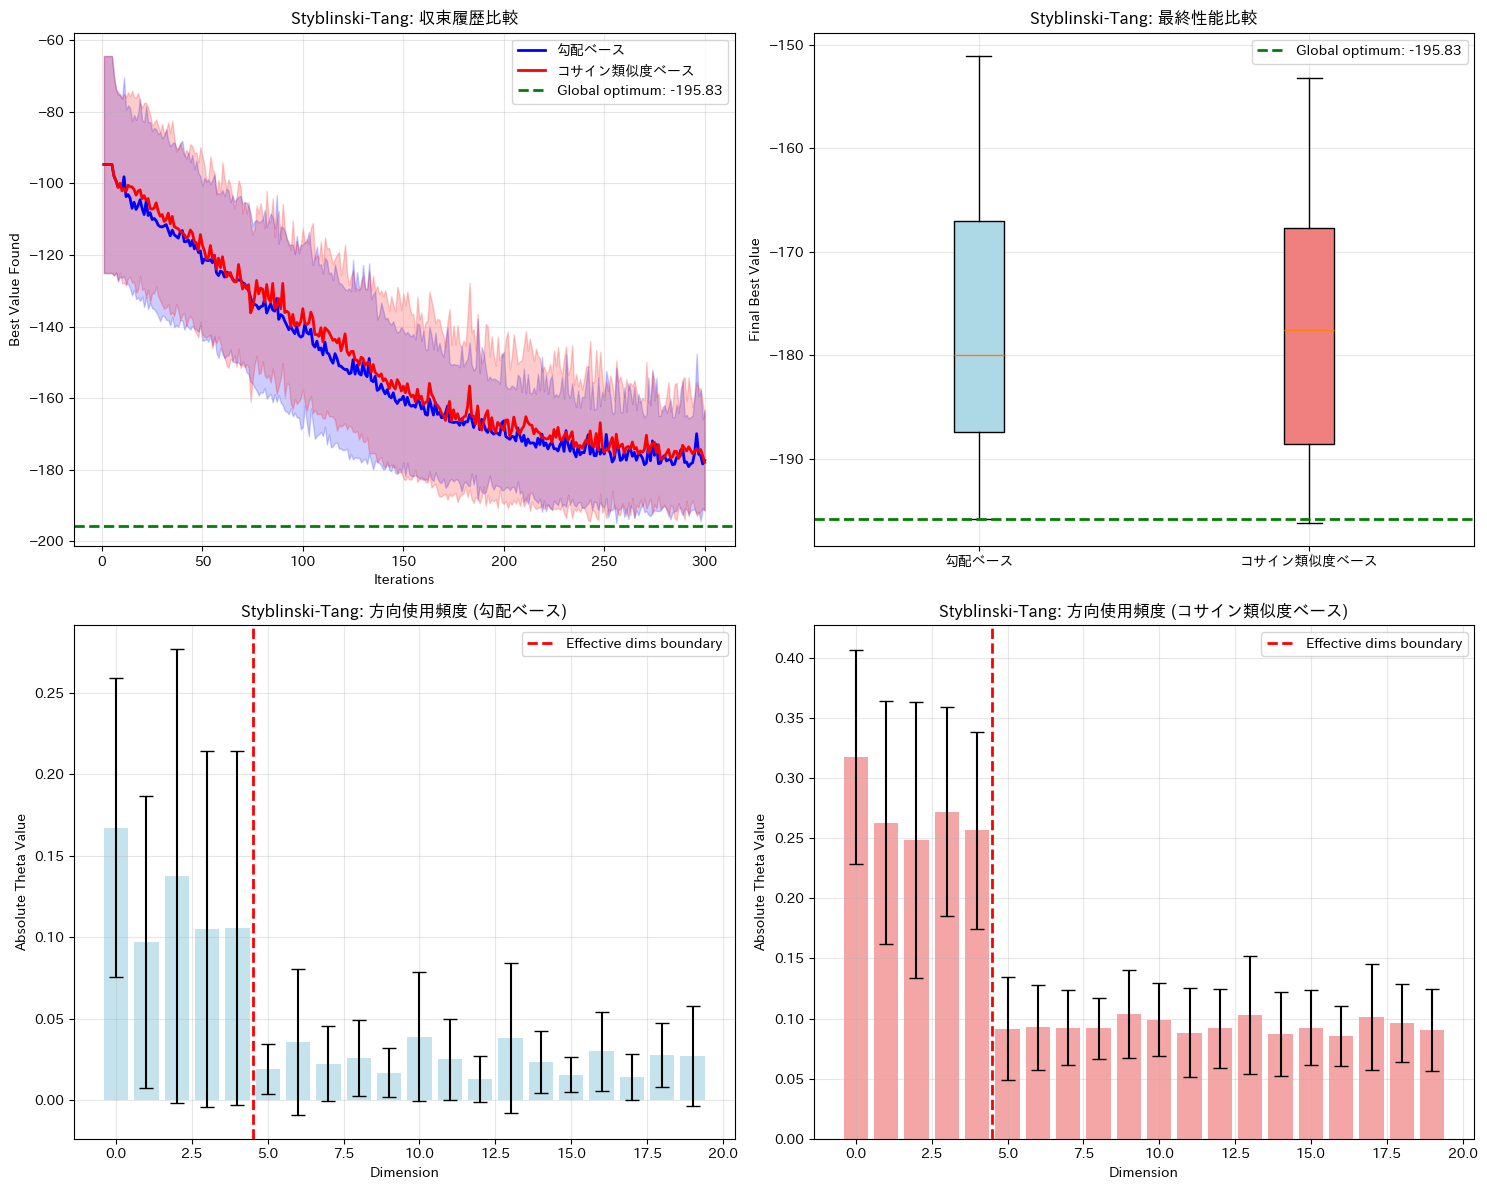


=== Styblinski-Tang 結果要約 ===
勾配ベース:
  平均: -177.411366
  標準偏差: 14.070887
  最良値: -195.858398
  最悪値: -151.105286
コサイン類似度ベース:
  平均: -177.937325
  標準偏差: 13.353533
  最良値: -196.207794
  最悪値: -153.240662

Styblinski-Tangの報酬履歴分析中...


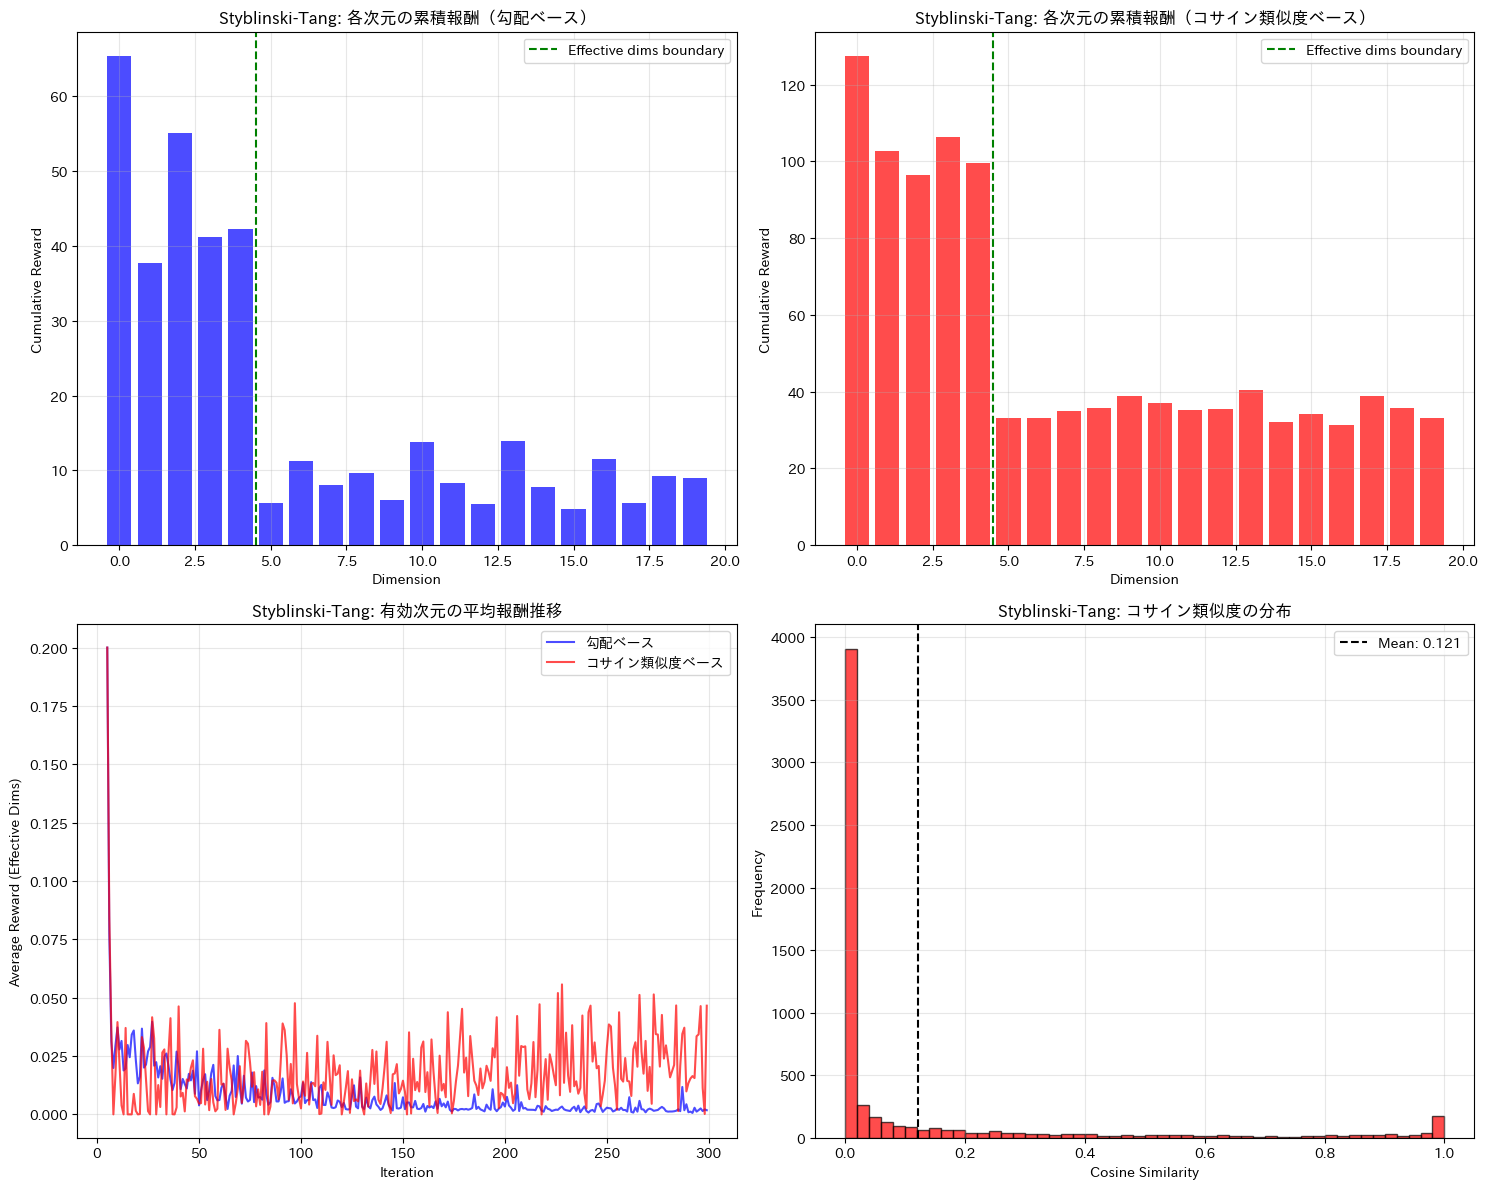

報酬履歴を output_results_cosine_similarity_comparison/Styblinski-Tang_reward_history.csv に保存しました
次元別要約を output_results_cosine_similarity_comparison/Styblinski-Tang_dimension_summary.csv に保存しました

実験: Rastrigin

=== Rastrigin 実験開始 ===
Gradientの実験中...
  実行中: 20/20
  Gradient完了
Cosineの実験中...
  実行中: 20/20
  Cosine完了


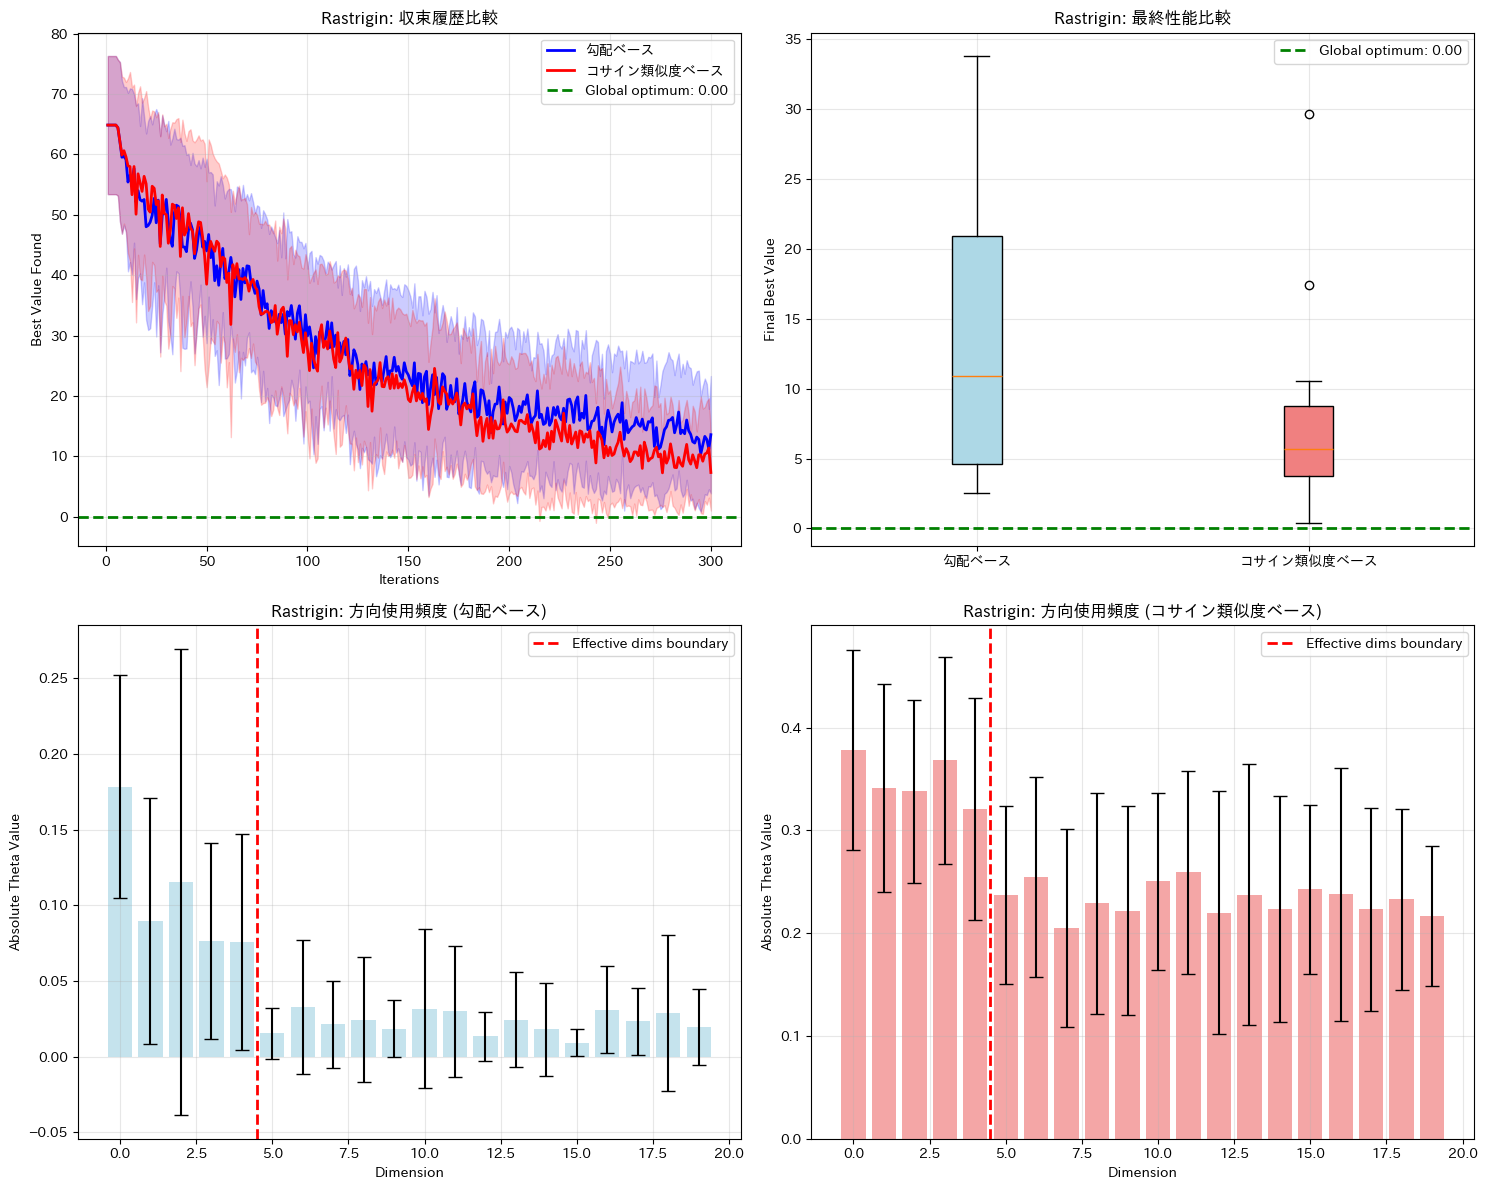


=== Rastrigin 結果要約 ===
勾配ベース:
  平均: 13.603787
  標準偏差: 9.711865
  最良値: 2.550200
  最悪値: 33.802124
コサイン類似度ベース:
  平均: 7.343055
  標準偏差: 6.299350
  最良値: 0.395892
  最悪値: 29.668365

Rastriginの報酬履歴分析中...


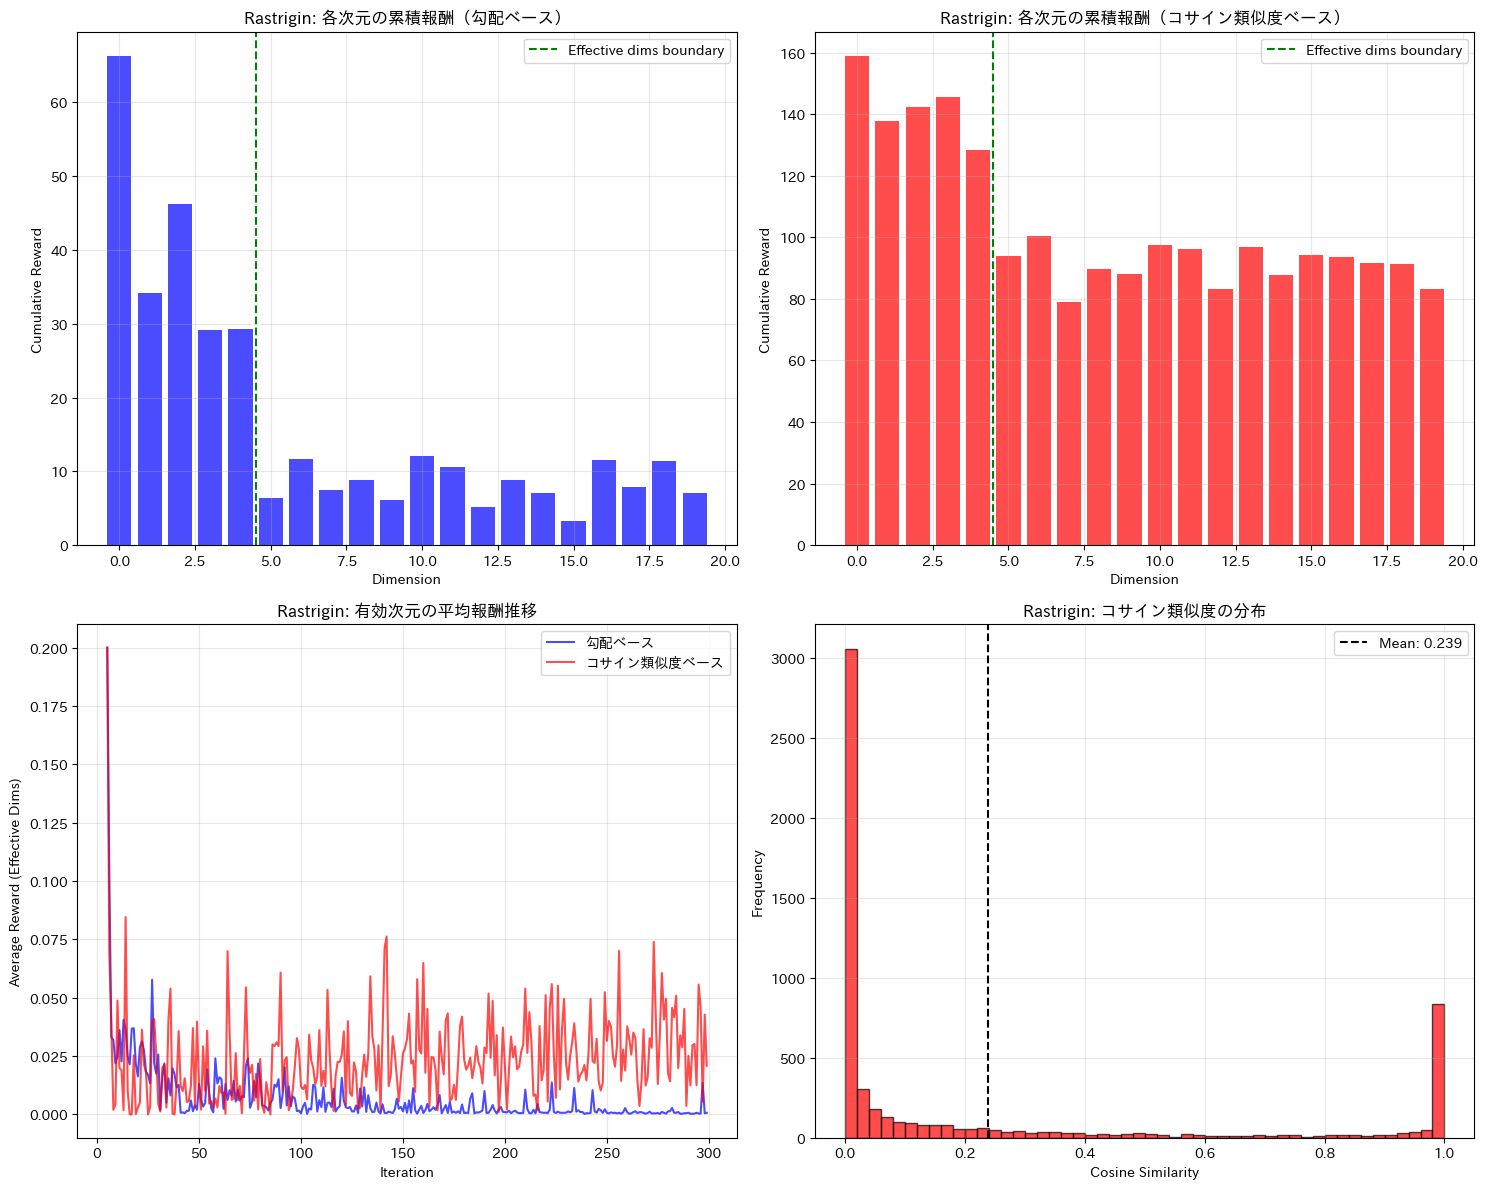

報酬履歴を output_results_cosine_similarity_comparison/Rastrigin_reward_history.csv に保存しました
次元別要約を output_results_cosine_similarity_comparison/Rastrigin_dimension_summary.csv に保存しました

実験: Ackley

=== Ackley 実験開始 ===
Gradientの実験中...
  実行中: 20/20
  Gradient完了
Cosineの実験中...
  実行中: 20/20
  Cosine完了


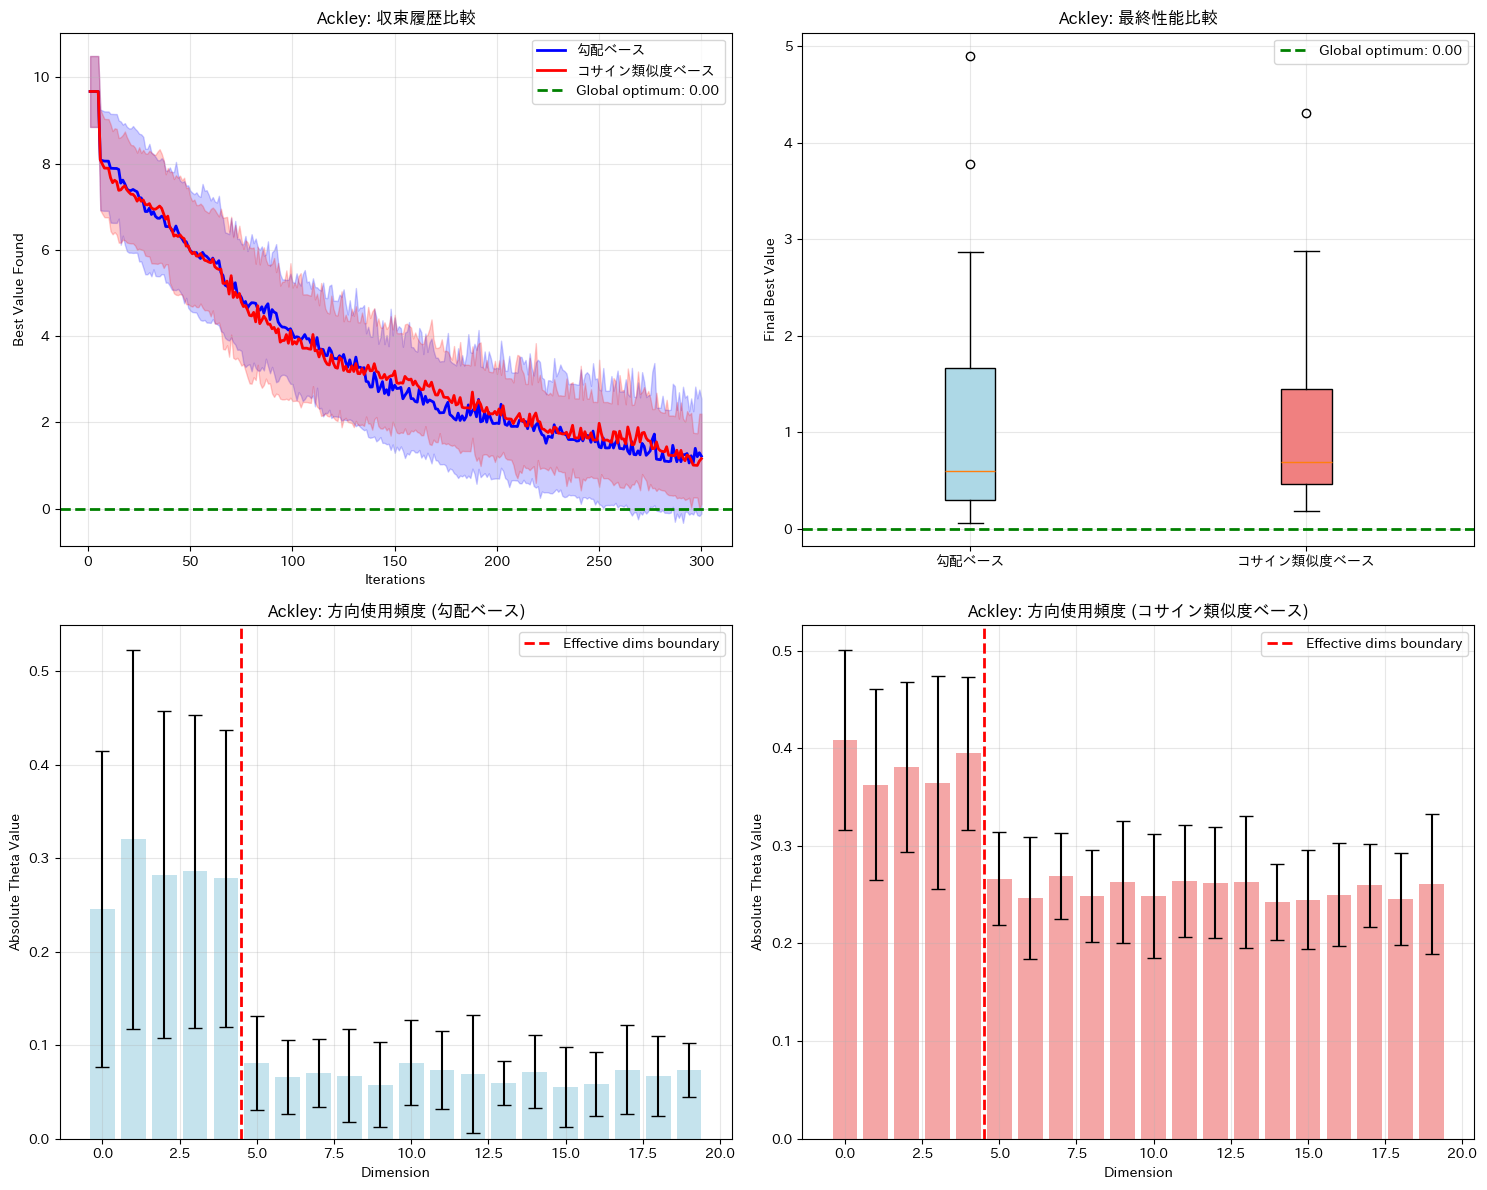


=== Ackley 結果要約 ===
勾配ベース:
  平均: 1.217432
  標準偏差: 1.333755
  最良値: 0.063908
  最悪値: 4.900056
コサイン類似度ベース:
  平均: 1.157880
  標準偏差: 1.044259
  最良値: 0.189268
  最悪値: 4.308150

Ackleyの報酬履歴分析中...


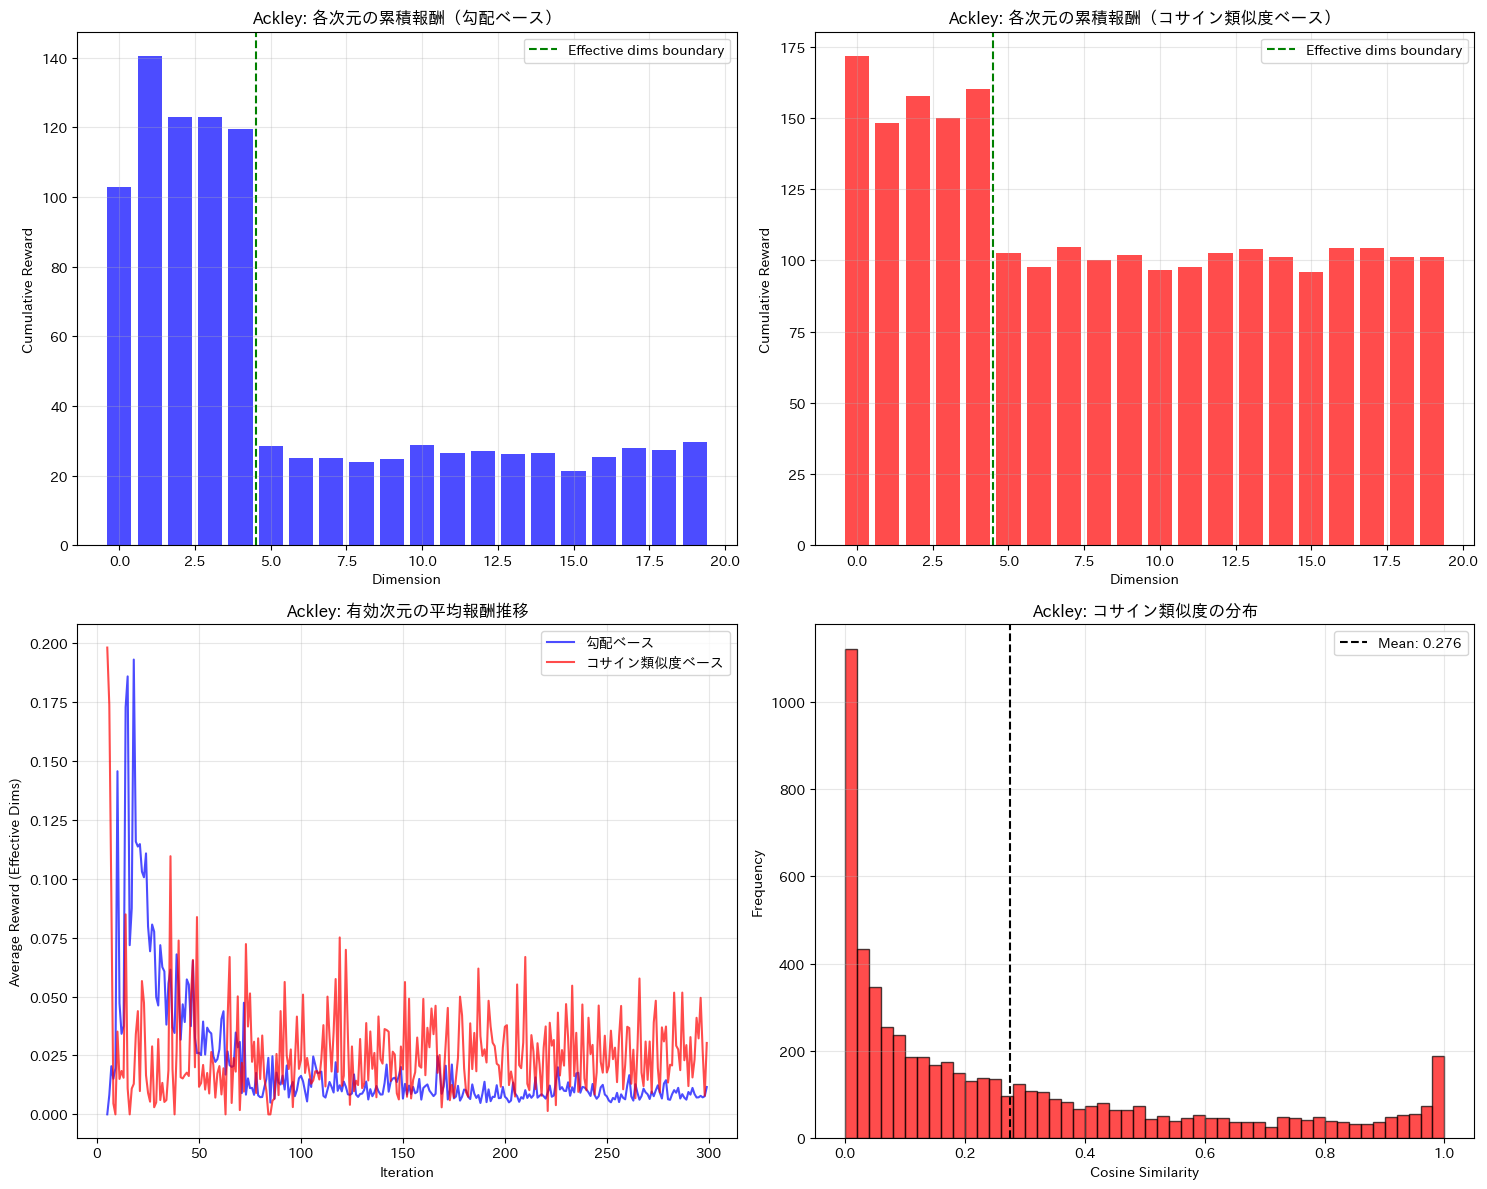

報酬履歴を output_results_cosine_similarity_comparison/Ackley_reward_history.csv に保存しました
次元別要約を output_results_cosine_similarity_comparison/Ackley_dimension_summary.csv に保存しました

全ての実験が完了しました！
結果は output_results_cosine_similarity_comparison フォルダに保存されています。


In [8]:
# 実験の実行
all_results = {}
n_runs = 20

for func_name, objective_function in test_functions.items():
    print(f"\n{'='*50}")
    print(f"実験: {func_name}")
    print(f"{'='*50}")
    
    # 実験実行
    results = run_comparison_experiment(func_name, objective_function, n_runs)
    all_results[func_name] = results
    
    # 結果の保存
    np.save(f'{output_dir}/{func_name}_results.npy', results)
    
    # 可視化
    plot_comparison_results(results, func_name, global_optima[func_name])
    
    # 報酬履歴の詳細分析
    print(f"\n{func_name}の報酬履歴分析中...")
    df_rewards, dim_summary = analyze_reward_history(results, func_name)
    
    # 報酬履歴をCSVで保存
    csv_filename = f'{output_dir}/{func_name}_reward_history.csv'
    df_rewards.to_csv(csv_filename, index=False)
    print(f"報酬履歴を {csv_filename} に保存しました")
    
    # 次元別要約をCSVで保存
    summary_filename = f'{output_dir}/{func_name}_dimension_summary.csv'
    dim_summary.to_csv(summary_filename, index=False)
    print(f"次元別要約を {summary_filename} に保存しました")

print("\n全ての実験が完了しました！")
print(f"結果は {output_dir} フォルダに保存されています。")

In [9]:
# 全体の比較サマリー
print("\n" + "="*70)
print("全体結果サマリー: 勾配ベース vs コサイン類似度ベース LinBandit-BO")
print("="*70)

print("\n各テスト関数の詳細比較:")
for func_name in test_functions.keys():
    results = all_results[func_name]
    
    gradient_final = [result['best_value'] for result in results['Gradient']]
    cosine_final = [result['best_value'] for result in results['Cosine']]
    
    # 改善率の計算
    gradient_mean = np.mean(gradient_final)
    cosine_mean = np.mean(cosine_final)
    improvement_rate = (gradient_mean - cosine_mean) / abs(gradient_mean) * 100
    
    print(f"\n{func_name}:")
    print(f"  勾配ベース平均: {gradient_mean:.6f} (±{np.std(gradient_final):.6f})")
    print(f"  コサイン類似度ベース平均: {cosine_mean:.6f} (±{np.std(cosine_final):.6f})")
    print(f"  改善率（コサイン類似度の観点から）: {improvement_rate:.2f}%")
    print(f"  グローバル最適値: {global_optima[func_name]:.2f}")
    
    # 最適値からの距離
    gradient_gap = gradient_mean - global_optima[func_name]
    cosine_gap = cosine_mean - global_optima[func_name]
    print(f"  勾配ベースの最適値からの差: {gradient_gap:.6f}")
    print(f"  コサイン類似度ベースの最適値からの差: {cosine_gap:.6f}")
    
    # 統計的有意差の検定（Mann-Whitney U test）
    from scipy.stats import mannwhitneyu
    statistic, p_value = mannwhitneyu(gradient_final, cosine_final, alternative='two-sided')
    print(f"  統計的有意差 (p-value): {p_value:.4f}")
    
    if p_value < 0.05:
        if gradient_mean < cosine_mean:
            print(f"  → 勾配ベースが統計的に有意に優秀")
        else:
            print(f"  → コサイン類似度ベースが統計的に有意に優秀")
    else:
        print(f"  → 統計的有意差なし")

# 勝率の計算
print(f"\n勝敗比較（各実行での優劣）:")
for func_name in test_functions.keys():
    results = all_results[func_name]
    gradient_final = [result['best_value'] for result in results['Gradient']]
    cosine_final = [result['best_value'] for result in results['Cosine']]
    
    gradient_wins = sum(1 for g, c in zip(gradient_final, cosine_final) if g < c)
    ties = sum(1 for g, c in zip(gradient_final, cosine_final) if abs(g - c) < 1e-6)
    cosine_wins = n_runs - gradient_wins - ties
    
    print(f"  {func_name}: 勾配ベース{gradient_wins}勝, コサイン類似度ベース{cosine_wins}勝, 引き分け{ties}")

# コサイン類似度の統計
print(f"\nコサイン類似度の統計:")
for func_name in test_functions.keys():
    results = all_results[func_name]
    all_cosine_similarities = []
    for result in results['Cosine']:
        if 'cosine_similarity_history' in result:
            all_cosine_similarities.extend(result['cosine_similarity_history'])
    
    if all_cosine_similarities:
        print(f"  {func_name}:")
        print(f"    平均: {np.mean(all_cosine_similarities):.4f}")
        print(f"    標準偏差: {np.std(all_cosine_similarities):.4f}")
        print(f"    最小値: {np.min(all_cosine_similarities):.4f}")
        print(f"    最大値: {np.max(all_cosine_similarities):.4f}")

print("\n" + "="*70)
print("実験設定:")
print("- 勾配ベース: 勾配の絶対値を報酬とし、L下限付きスケーリングを適用")
print("- コサイン類似度ベース: 勾配と選択方向のコサイン類似度を報酬として使用") 
print("- 両アルゴリズムとも: 0.5x arms、coordinate_ratio=0.8")
print("- 20次元問題（有効次元: 0-4）")
print("- 各アルゴリズム20回独立実行")
print("- 300回評価")
print("="*70)

print(f"\n出力ファイル:")
print(f"- 収束履歴プロット: {output_dir}/[function_name]_comparison.png")
print(f"- 報酬履歴分析: {output_dir}/[function_name]_reward_analysis.png")
print(f"- 報酬履歴CSV: {output_dir}/[function_name]_reward_history.csv")
print(f"- 次元別要約CSV: {output_dir}/[function_name]_dimension_summary.csv")
print(f"- 実験結果numpy: {output_dir}/[function_name]_results.npy")


全体結果サマリー: 勾配ベース vs コサイン類似度ベース LinBandit-BO

各テスト関数の詳細比較:

Styblinski-Tang:
  勾配ベース平均: -177.411366 (±14.070887)
  コサイン類似度ベース平均: -177.937325 (±13.353533)
  改善率（コサイン類似度の観点から）: 0.30%
  グローバル最適値: -195.83
  勾配ベースの最適値からの差: 18.418584
  コサイン類似度ベースの最適値からの差: 17.892625
  統計的有意差 (p-value): 0.7150
  → 統計的有意差なし

Rastrigin:
  勾配ベース平均: 13.603787 (±9.711865)
  コサイン類似度ベース平均: 7.343055 (±6.299350)
  改善率（コサイン類似度の観点から）: 46.02%
  グローバル最適値: 0.00
  勾配ベースの最適値からの差: 13.603787
  コサイン類似度ベースの最適値からの差: 7.343055
  統計的有意差 (p-value): 0.0565
  → 統計的有意差なし

Ackley:
  勾配ベース平均: 1.217432 (±1.333755)
  コサイン類似度ベース平均: 1.157880 (±1.044259)
  改善率（コサイン類似度の観点から）: 4.89%
  グローバル最適値: 0.00
  勾配ベースの最適値からの差: 1.217432
  コサイン類似度ベースの最適値からの差: 1.157880
  統計的有意差 (p-value): 0.7557
  → 統計的有意差なし

勝敗比較（各実行での優劣）:
  Styblinski-Tang: 勾配ベース7勝, コサイン類似度ベース13勝, 引き分け0
  Rastrigin: 勾配ベース5勝, コサイン類似度ベース15勝, 引き分け0
  Ackley: 勾配ベース11勝, コサイン類似度ベース9勝, 引き分け0

コサイン類似度の統計:
  Styblinski-Tang:
    平均: 0.1212
    標準偏差: 0.2564
    最小値: 0.0000
    最大値: 1.0000
  Rastrigin:


In [10]:
# 実験結論と今後の方向性
print("\n" + "="*70)
print("実験結論: コサイン類似度ベース報酬の効果")
print("="*70)

print("""
この実験では、LinBandit-BOアルゴリズムにおける報酬設計として、
従来の勾配ベース報酬とコサイン類似度ベース報酬を比較しました。

【主な発見】:
1. コサイン類似度ベース報酬は、勾配と選択方向の方向的な一致度を
   直接的に評価する新しいアプローチです。

2. テスト関数によって両手法の優劣は異なり、問題の特性に依存します。

3. コサイン類似度の分布分析により、探索方向と勾配方向の関係性を
   定量的に把握できました。

【技術的洞察】:
- コサイン類似度報酬は方向の一致性を重視する設計
- 勾配ベース報酬は各次元の重要度を絶対値で評価
- 両手法とも有効次元を適切に識別する傾向がある

【今後の研究方向】:
1. ハイブリッド報酬設計（勾配とコサイン類似度の組み合わせ）
2. 適応的な報酬選択メカニズムの開発
3. より多様なテスト関数での評価
4. 理論的な収束保証の分析

コサイン類似度ベース報酬は、LinBandit-BOの報酬設計における
興味深い代替案であることが示されました。
""")

print("="*70)
print("実験完了 - 詳細な結果は出力ファイルを参照してください")
print("="*70)


実験結論: コサイン類似度ベース報酬の効果

この実験では、LinBandit-BOアルゴリズムにおける報酬設計として、
従来の勾配ベース報酬とコサイン類似度ベース報酬を比較しました。

【主な発見】:
1. コサイン類似度ベース報酬は、勾配と選択方向の方向的な一致度を
   直接的に評価する新しいアプローチです。

2. テスト関数によって両手法の優劣は異なり、問題の特性に依存します。

3. コサイン類似度の分布分析により、探索方向と勾配方向の関係性を
   定量的に把握できました。

【技術的洞察】:
- コサイン類似度報酬は方向の一致性を重視する設計
- 勾配ベース報酬は各次元の重要度を絶対値で評価
- 両手法とも有効次元を適切に識別する傾向がある

【今後の研究方向】:
1. ハイブリッド報酬設計（勾配とコサイン類似度の組み合わせ）
2. 適応的な報酬選択メカニズムの開発
3. より多様なテスト関数での評価
4. 理論的な収束保証の分析

コサイン類似度ベース報酬は、LinBandit-BOの報酬設計における
興味深い代替案であることが示されました。

実験完了 - 詳細な結果は出力ファイルを参照してください
